In [1]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.


In [2]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [3]:
def target_category_loss_output_shape(input_shape):
    return input_shape

In [4]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [5]:
def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [6]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [7]:
def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [8]:
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

In [9]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [155]:
path = '/home/pardha/waste/fotolia_8527249_XS.jpg'
# path = '/home/pardha/Desktop/32986517-set-of-indian-peafowl-and-other-asian-animals-isolated-on-white.jpg'
preprocessed_input = load_image(path)

model = VGG16(weights='imagenet')

In [156]:
predictions = model.predict(preprocessed_input)

In [157]:
predictions.max()

0.13977093

In [158]:
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

Predicted class:
Pomeranian (n02112018) with probability 0.14


In [159]:
top_2 = decode_predictions(predictions)[0][1]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_2[1], top_2[0], top_2[2]))

Predicted class:
Persian_cat (n02123394) with probability 0.14


In [160]:
decode_predictions(predictions)

[[('n02112018', 'Pomeranian', 0.13977093),
  ('n02123394', 'Persian_cat', 0.13740557),
  ('n02123045', 'tabby', 0.11572635),
  ('n03825788', 'nipple', 0.038364038),
  ('n04409515', 'tennis_ball', 0.033004392)]]

In [161]:
decode_predictions(predictions)[0][0]

('n02112018', 'Pomeranian', 0.13977093)

In [162]:
np.argmax(predictions)

259

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt

IndexError: too many indices for array

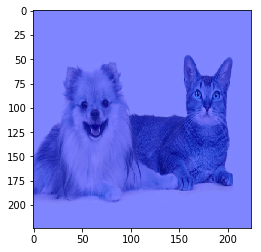

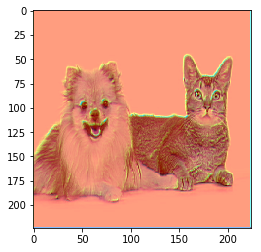

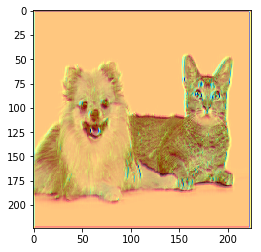

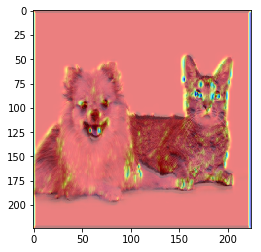

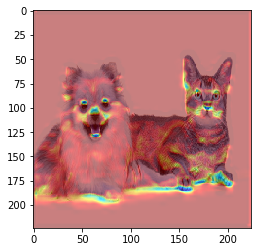

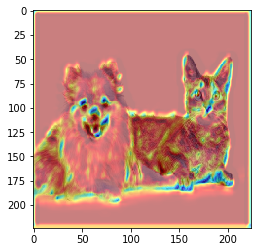

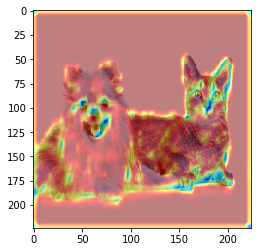

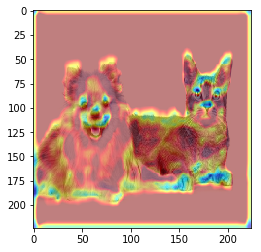

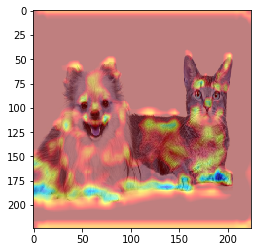

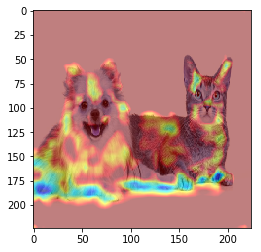

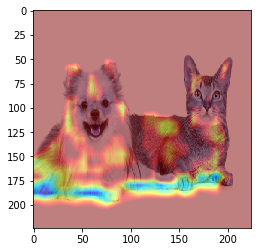

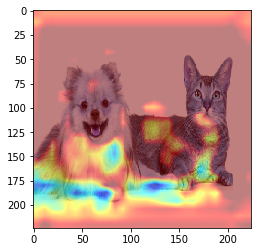

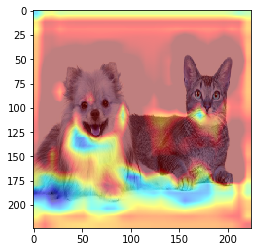

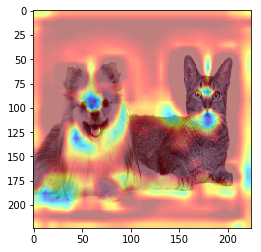

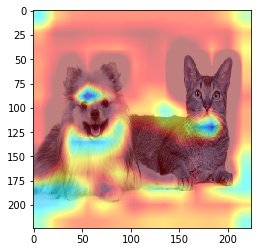

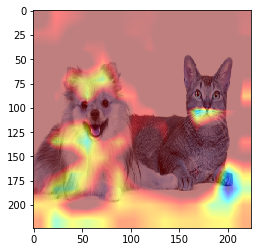

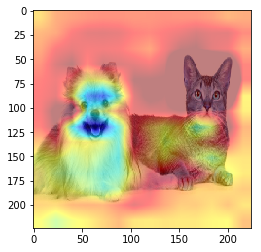

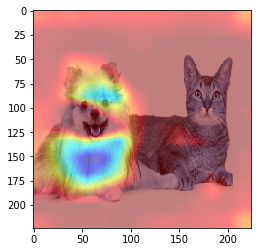

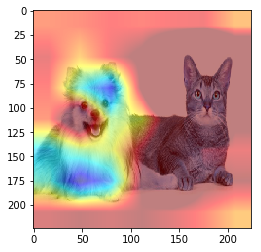

In [164]:
predicted_class = np.argmax(predictions)

for i,layer_name in enumerate([l.name for l in model.layers]):
    cam, heatmap = grad_cam(model, preprocessed_input, 283, layer_name)
    # cv2.imwrite("gradcam.jpg", cam)
    plt.figure(i)
    plt.imshow(cam)


# register_gradient()
# guided_model = modify_backprop(model, 'GuidedBackProp')
# saliency_fn = compile_saliency_function(guided_model)
# saliency = saliency_fn([preprocessed_input, 0])
# gradcam = saliency[0] * heatmap[..., np.newaxis]
# cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam_block1_conv1.jpg))

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten',
 'fc1',
 'fc2',
 'predictions']